## Transfer Learning ResNet50V2 using Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set the seed for reproducibility
tf.random.set_seed(42)

In [ ]:
# Define the hyperparameters
batch_size = 32
epochs = 7
learning_rate = 0.001

In [ ]:
# Load the data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/data/train', 
                                                    target_size=(224, 224), batch_size=batch_size, 
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/data/test', 
                                                        target_size=(224, 224), batch_size=batch_size, 
                                                        class_mode='categorical')

Found 1600 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [ ]:
# Define the model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(1)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Define the optimizer and compile the model
optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/ResNet50V2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
callbacks_list = [early_stopping, model_checkpoint, reduce_lr_on_plateau]

In [ ]:
# Calculate the size of the model
total_params = sum(p.numpy().nbytes for p in model.trainable_variables)
print(f"Total parameters size: {total_params / (1024 * 1024):.2f} MB")

Total parameters size: 286.23 MB


In [ ]:
num_layers = len(model.layers)
print(f"Number of layers: {num_layers}")

Number of layers: 196


In [ ]:
# Train the model
history = model.fit(train_generator, epochs=epochs, 
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/7
50/50 [==============================] - ETA: 0s - loss: 1.7892 - accuracy: 0.4844 
Epoch 1: val_accuracy improved from -inf to 0.42500, saving model to /content/gdrive/MyDrive/ResNet50V2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 1361s 27s/step - loss: 1.7892 - accuracy: 0.4844 - val_loss: 1.8545 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 2/7
50/50 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.7738
Epoch 2: val_accuracy improved from 0.42500 to 0.52250, saving model to /content/gdrive/MyDrive/ResNet50V2.h5
50/50 [==============================] - 161s 3s/step - loss: 0.6403 - accuracy: 0.7738 - val_loss: 1.4403 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 3/7
50/50 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8669
Epoch 3: val_accuracy improved from 0.52250 to 0.92500, saving model to /content/gdrive/MyDrive/ResNet50V2.h5
50/50 [==============================] - 155s 3s/step - loss: 0.3903 - accuracy: 0.8669 - val_loss: 0.2607 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/7
50/50 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9050
Epoch 4: val_accuracy did not improve from 0.92500
50/50 [============

In [ ]:
# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/data/test', 
                                                  target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', shuffle=False)
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Found 400 images belonging to 5 classes.
13/13 [==============================] - 22s 2s/step


In [ ]:
# Generate and print the classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
print(cm)

               precision    recall  f1-score   support

  corrugation       1.00      1.00      1.00        80
      flaking       0.83      0.97      0.90        80
non-defective       0.96      0.84      0.89        80
     shelling       1.00      0.95      0.97        80
       squats       1.00      1.00      1.00        80

     accuracy                           0.95       400
    macro avg       0.96      0.95      0.95       400
 weighted avg       0.96      0.95      0.95       400

[[80  0  0  0  0]
 [ 0 78  2  0  0]
 [ 0 13 67  0  0]
 [ 0  3  1 76  0]
 [ 0  0  0  0 80]]


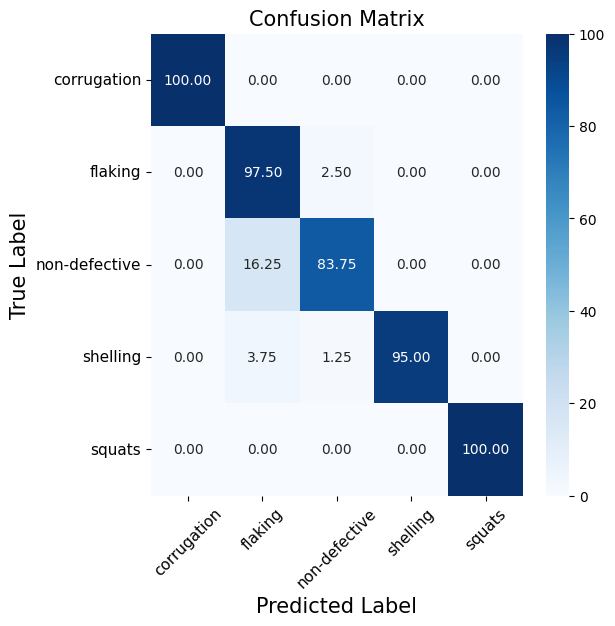

Accuracy: 95.25


In [ ]:
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)*100
# Normalize
cmnx = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = cmnx*100
fig, ax = plt.subplots(figsize=(6,6))
# Plot confusion matrix
g = sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#g = sns.heatmap(data,linewidth=0,yticklabels=yticks,xticklabels=xticks)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 11)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 11)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.show()
print(f"Accuracy: {accuracy}")

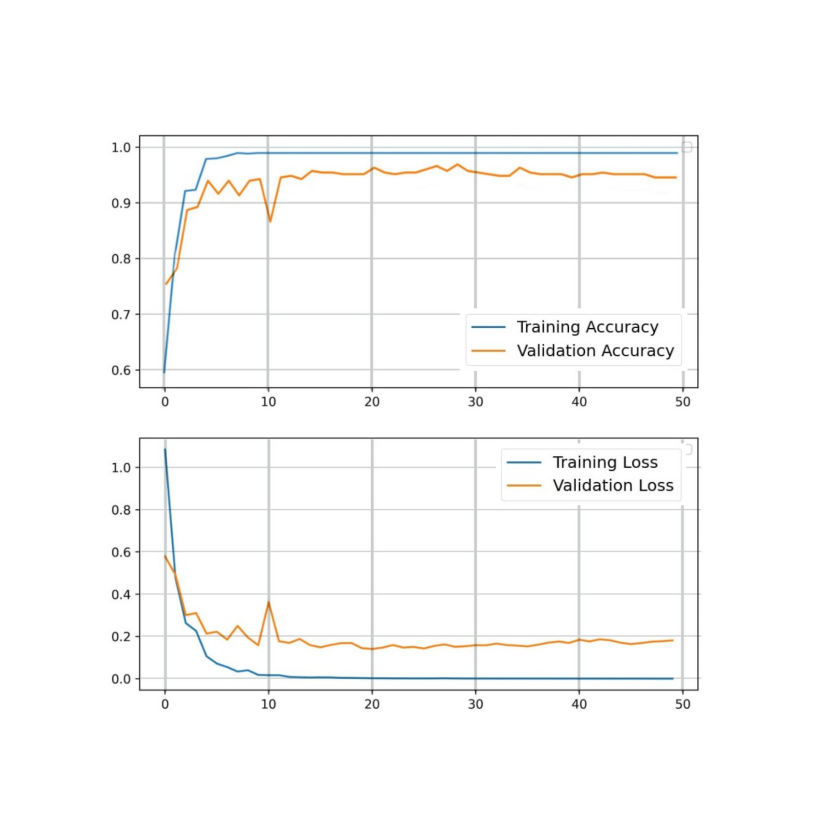

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.legend()
ax1.grid(True)
# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('Training_Validation_Metrics.png')
plt.show()

In [ ]:
# Save the model to a file
model.save('ResNet50V2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
